# Coherent Averaging/Filtering experiments

Generate a Gaussian random array of complex values. Consider this as visibilities over time. Experiment with averaging this down, before and after filtering. The filter is a tophat filter.

For simulated noise the filter_avg function does the work. It will
* generate the visibility array
* filter it with the tophat
* figure out the width of the sinc corresponding to the tophat
* coherently average the filtered data using the width of the sinc

Check it.

In [1]:
from pyuvdata import UVData
import numpy as np
from astropy import units
import uvtools
import matplotlib.pyplot as plt

In [2]:
def coh_average(x, length):
    # x has to be a multiple of length
    dlength = (x.size//length)*length
    return np.mean(x[:dlength].reshape(-1, length), 1) 

r = lambda x: np.round(x, 4)

def rms(data):
    # Data should be real
    return np.sqrt(np.mean(data**2))


def filter_avg(length, half_width, return_this="data"):
    """
    length: length of noise data array
    half_width: half width of tophat in array indexes (no units).
                E.g. if length is 1000 the half_width might be 10.
                
    Returns: various things
    """
    mask = np.zeros(length)
    mask[length//2-half_width:length//2+half_width] = 1
    sinc = np.abs(np.fft.fftshift(np.fft.fft(mask)))
    
    # Find width of sinc by starting at the peak of the mainlobe and scanning forward until there is a
    # turning point. The values will drop down the side of the mainlobe to the turning point.
    # BTW The rule is actually sinc_width = 1/half_width*length
    last_val = sinc[sinc.size//2]
    i = sinc.size//2+1
    while sinc[i] < last_val:

        last_val = sinc[i]
        i += 1
        
    smoothing_time = (i-1-sinc.size//2)*2     # coherent averaging time
    if return_this == "stats":
        print("Smoothing time from sinc", str(r(smoothing_time/length*100))+"%,", smoothing_time, "pixels")
        print("Smoothing time from rule", str(r((1/half_width*length)/length*100))+"%,", int(1/half_width*length), "pixels\n")
    
    # Now the data runs
    data = np.random.normal(size=length)+np.random.normal(size=length)*1j
    
    # Do filter
    filtered = np.fft.fftshift(np.fft.fft(data))*mask
    filtered_data = np.fft.ifft(np.fft.ifftshift(filtered))
    
    # Do averaging
    data_av = coh_average(data, smoothing_time)
    filtered_data_av = coh_average(filtered_data, smoothing_time)
    
    if return_this == "stats":
        print("RMS data real", r(rms(data.real)))
        print("RMS data imag", r(rms(data.imag)))
        print()
        print("RMS filtered data real", r(rms(filtered_data.real)))
        print("RMS filtered data imag", r(rms(filtered_data.imag)))
        print()
        print("RMS filtered averaged data real", r(rms(filtered_data_av.real)))
        print("RMS filtered averaged data imag", r(rms(filtered_data_av.imag)))
        print()
        print("RMS averaged data real", r(rms(data_av.imag)))
        print("RMS averaged data imag", r(rms(data_av.imag)))
        
    elif return_this == "comparison":
        sigma_data_av_real = np.std(data_av.real)
        sigma_filtered_data_av_real = np.std(filtered_data_av.real)
        sigma_data_av_imag = np.std(data_av.imag)
        sigma_filtered_data_av_imag = np.std(filtered_data_av.imag)
        
        # % diff between the averaged filtered data and the averaged unfiltered data
        return abs(sigma_data_av_real-sigma_filtered_data_av_real)/sigma_data_av_real*100, \
                    abs(sigma_data_av_imag-sigma_filtered_data_av_imag)/sigma_data_av_imag*100
    
    elif return_this == "data":
        return data, filtered_data, smoothing_time
    
    elif return_this == "averaged_data":
        return data_av, filtered_data_av, smoothing_time



## 1. Simulation Plots

Unfiltered and filtered data. Length is $2^{20}$.

In [3]:
data, filtered, l = filter_avg(1048576, 4096, return_this="data")
print("The coherent averaging length is", l, "array elements")

The coherent averaging length is 256 array elements


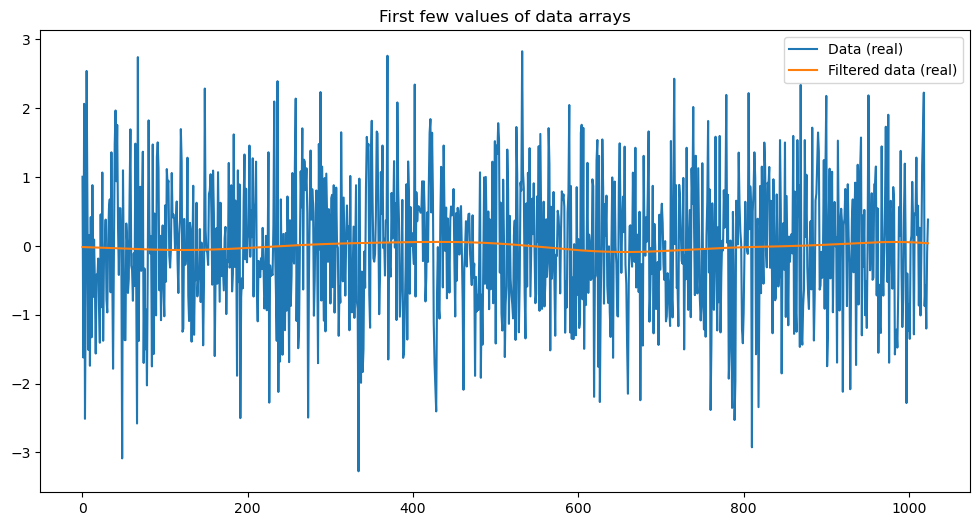

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(data[:1024].real, label="Data (real)")
plt.plot(filtered[:1024].real, label="Filtered data (real)")
plt.title("First few values of data arrays")
plt.legend()

The filtered data is way below the data.

Now look at the averaged data.

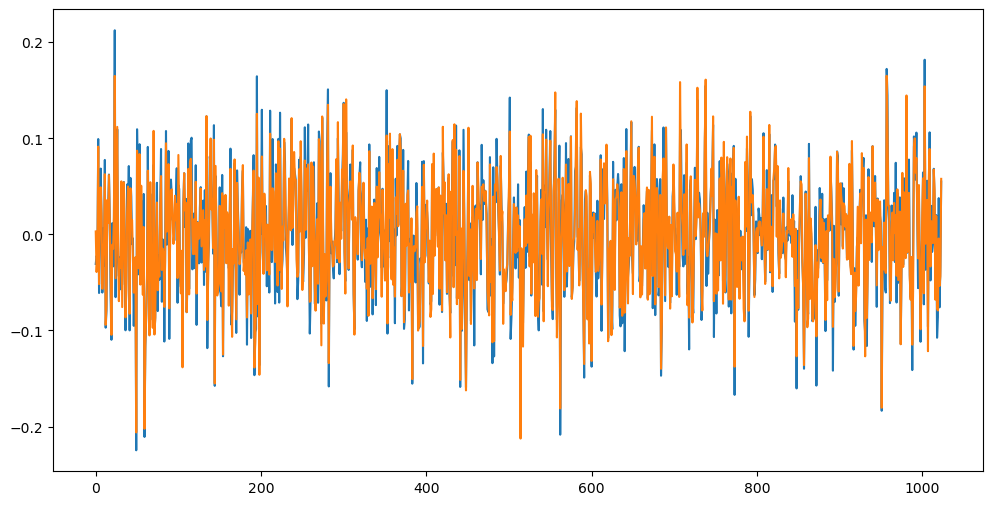

In [5]:
data, filtered, l = filter_avg(1024*1024, 4096, return_this="averaged_data")
plt.figure(figsize=(12, 6))
plt.plot(data[:1024].real, label="Averaged data (real)")
plt.plot(filtered[:1024].real, label="Filtered data (real)")

They are the same.

Now run some numbers.

## 2. Check that the filtered noise is actually correlated.

* use a smaller length
* generate 1000s of instances of filtered data
* examine a chunk of data equal to the coherent averging length
* generate a covariance matrix from all the instances of that chunk

In [6]:
NUM_TRIALS = 1000
DATA_LENGTH = 1024
START_OF_CHUNK = 400
trials = np.zeros((NUM_TRIALS, DATA_LENGTH), dtype=np.complex128)
trials_filtered = np.zeros((NUM_TRIALS, DATA_LENGTH), dtype=np.complex128)
for i in range(NUM_TRIALS):
    data, filtered_data, sinc_width = filter_avg(1024, 12, return_this="data")
    trials[i] = data
    trials_filtered[i] = filtered_data
    


Covariance of the data chunk should be diagonal

Text(0.5, 1.0, 'Covariance of Data, real')

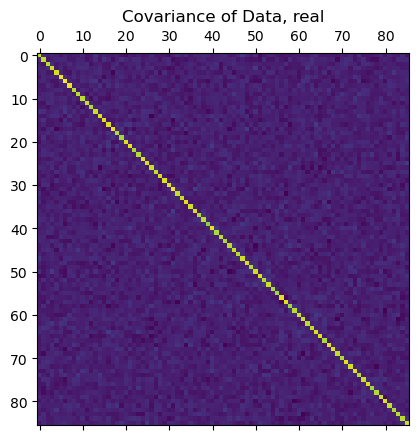

In [7]:
trials = trials[:, START_OF_CHUNK:START_OF_CHUNK+sinc_width]

cov = np.cov(trials.real.T)
plt.matshow(cov)
plt.title("Covariance of Data, real")

Try the filtered data

Text(0.5, 1.0, 'Covariance of Filtered Data, real')

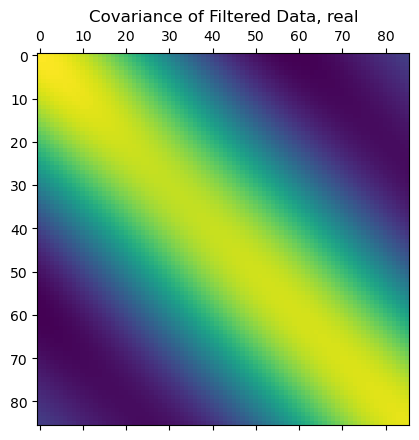

In [8]:
tf = trials_filtered[:, START_OF_CHUNK:START_OF_CHUNK+sinc_width]

cov = np.cov(tf.real.T)
plt.matshow(cov)
plt.title("Covariance of Filtered Data, real")

Try a different chunk of the filtered data

Text(0.5, 1.0, 'Covariance of Filtered Data, real')

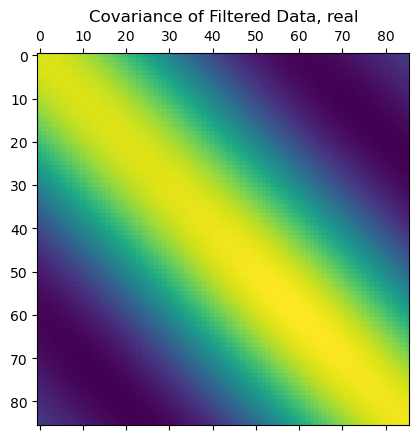

In [9]:
tf = trials_filtered[:, START_OF_CHUNK+123:START_OF_CHUNK+123+sinc_width]

cov = np.cov(tf.real.T)
plt.matshow(cov)
plt.title("Covariance of Filtered Data, real")

Try two contiguous chunks of the filtered data


Text(0.5, 1.0, 'Covariance of Filtered Data, real')

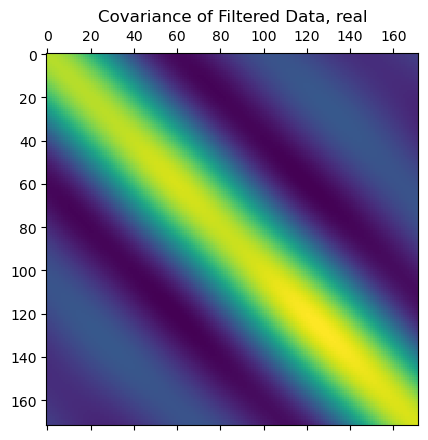

In [10]:
tf = trials_filtered[:, START_OF_CHUNK+123:START_OF_CHUNK+123+sinc_width*2]

cov = np.cov(tf.real.T)
plt.matshow(cov)
plt.title("Covariance of Filtered Data, real")

**Yes the filtered data is roughly correlated as expected**

## 3. Compare unfiltered averaged data against filtered averaged data, numerically

This means calculate the standard deviation of unfiltered averaged data and filtered averaged data. The function filter_avg() can print these.

In [11]:
filter_avg(1024*1024, 4096, return_this="stats")

Smoothing time from sinc 0.0244%, 256 pixels
Smoothing time from rule 0.0244%, 256 pixels

RMS data real 1.0
RMS data imag 0.9992

RMS filtered data real 0.0886
RMS filtered data imag 0.0893

RMS filtered averaged data real 0.0593
RMS filtered averaged data imag 0.06

RMS averaged data real 0.0631
RMS averaged data imag 0.0631


===========================

The important numbers are these:
    
*Stats of filtered averaged data*

    Sigma filtered averaged data real 0.0023
    Sigma filtered averaged data imag 0.0025
    
*Stats of unfiltered averaged data*

    Sigma averaged data real 0.0025
    Sigma averaged data imag 0.0025
    
**Conclusion: the numbers are very close, the noise level is the same.**

## 4. HERA simulated data and fringe rate filtering

In [12]:


def fringe_rates(uu):
    times = np.unique(uu.time_array)
    fr = uvtools.utils.fourier_freqs(times * units.day.to("s"))
    fr *= units.Hz.to("mHz")
    
    return fr

def fft(data):
    return np.fft.fftshift(np.fft.fft(data))

def climits(ca1, ca2):
    mmax = max(np.max(ca1.real), np.max(ca2.real), 
               max(np.max(ca1.imag), np.max(ca2.imag)))*1.05
    mmin = min(np.min(ca1.real), np.min(ca2.real), 
               min(np.min(ca1.imag), np.min(ca2.imag)))*1.05
    
    return (mmin, mmax)

def rlimits(ra1, ra2):
    
    mmax = max(np.max(ra1.real), np.max(ra2.real))*1.05
    mmin = min(np.min(ra1.real), np.min(ra2.real))*1.05
    
    return (mmin, mmax)


Telescope hera_sim is not in known_telescopes.


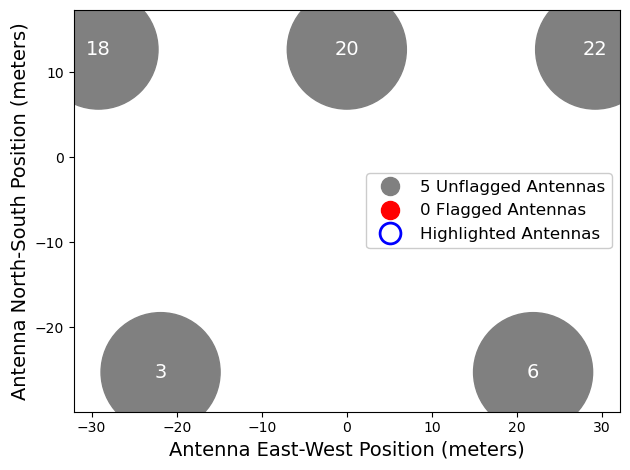

In [26]:
uvd = UVData()
uvd.read_uvh5("fringe_rate_filter_paper/non-redundant-pipeline_notch/calibration_points_batch/viscatBC_group_1_d.uvh5",
             read_data=False)
ants = {}
numbers = uvd.antenna_numbers
pos = uvd.get_ENU_antpos()[0]
for i in range(numbers.size):
    ants[numbers[i]] = pos[i]
uvtools.plot.plot_antpos(ants)

In [27]:
bl = (18, 22)
ext = "_d"

In [28]:
uvd = UVData()
uvd.read_uvh5("fringe_rate_filter_paper/non-redundant-pipeline_notch/calibration_points_batch/viscatBC_group_1"+ext+".uvh5")
filtered_uvd = UVData()
filtered_uvd.read_uvh5("fringe_rate_filter_paper/non-redundant-pipeline_notch/calibration_points_batch/filtered_viscatBC_group_1"+ext+".uvh5")


Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.


In [29]:
bl_data = uvd.get_data(bl, "XX")[:, 0]
filtered_bl_data = filtered_uvd.get_data(bl, "XX")[:, 0]

Text(0.5, 0.98, 'Fringe rates for Data and Filtered data')

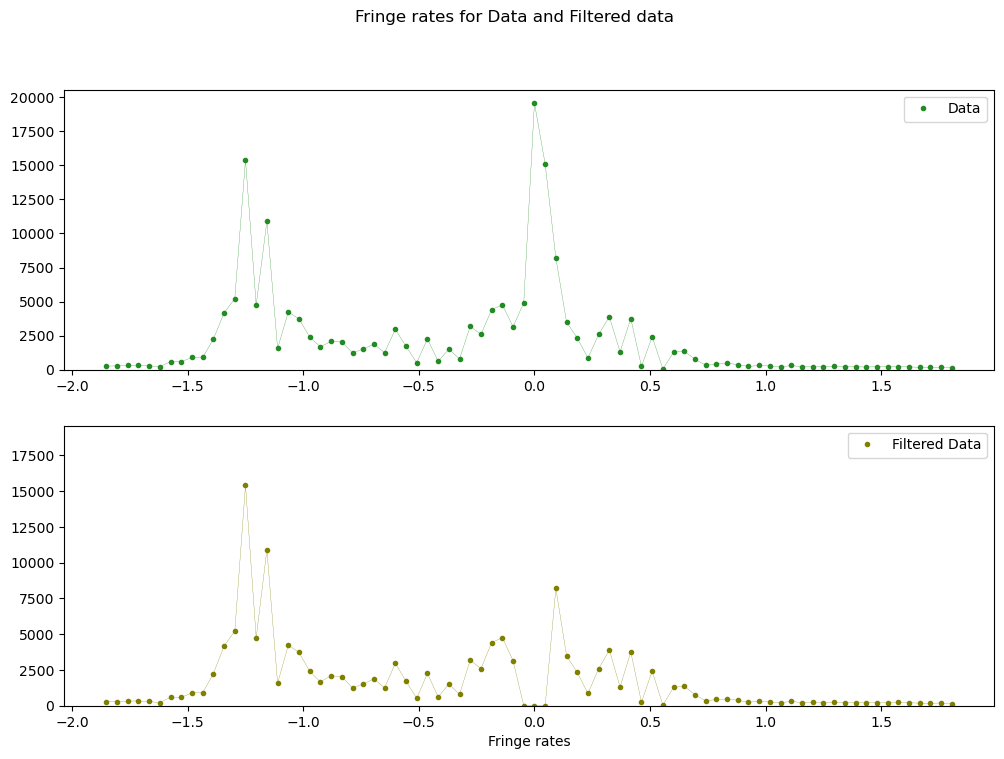

In [30]:
frates = fringe_rates(uvd)
plt.figure(figsize=(12, 8))
cut = 40
fr = np.abs(fft(bl_data))
low = frates.size//2-cut
high = frates.size//2+cut
plt.subplot(2, 1, 1)
plt.plot(frates[low:high], fr[low:high], ".", label="Data", color="forestgreen")
plt.plot(frates[low:high], fr[low:high], lw=0.2, color="forestgreen")

plt.ylim(0, np.max(fr)*1.05)
plt.legend()
plt.subplot(2, 1, 2)
filtered_fr = np.abs(fft(filtered_bl_data))
plt.plot(frates[low:high], filtered_fr[low:high], ".", label="Filtered Data", color="olive")
plt.plot(frates[low:high], filtered_fr[low:high], lw=0.2, color="olive")
plt.ylim(0, np.max(fr)*1.0)
plt.xlabel("Fringe rates")
plt.legend()
plt.suptitle("Fringe rates for Data and Filtered data")

Text(0.5, 0.98, 'Data and Filtered data')

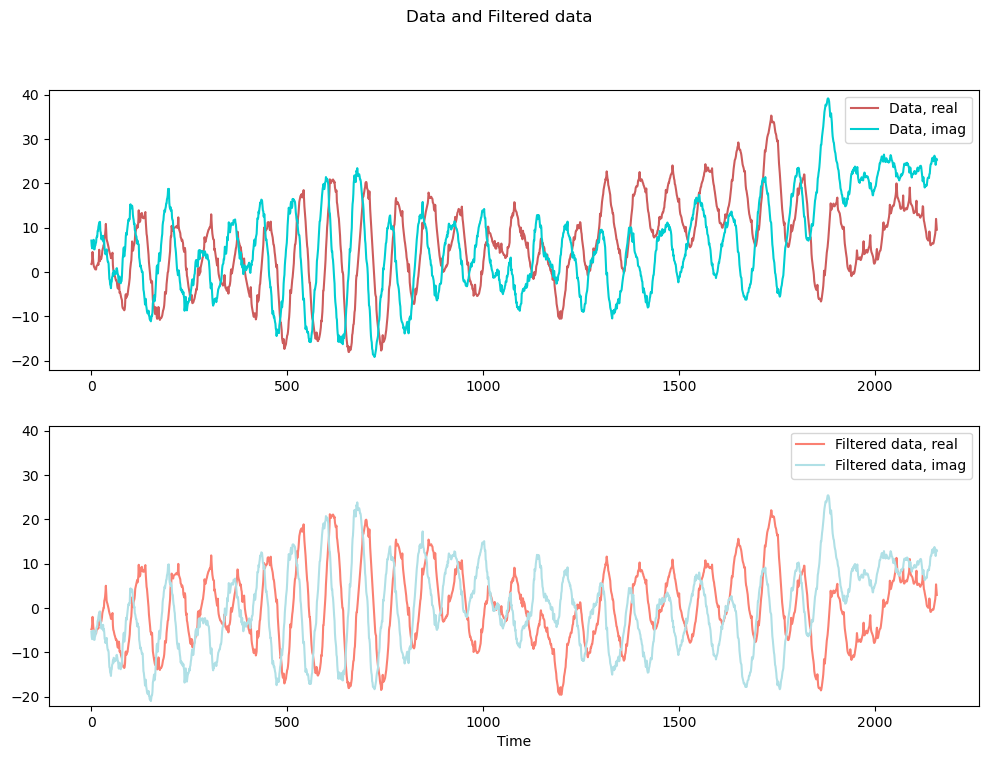

In [31]:

low, high = climits(bl_data, filtered_bl_data)

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(bl_data.real, label="Data, real", color="indianred")
plt.plot(bl_data.imag, label="Data, imag", color="darkturquoise")
plt.ylim(low, high)

plt.legend()
plt.subplot(2, 1, 2)
plt.plot(filtered_bl_data.real, label="Filtered data, real", color="salmon")
plt.plot(filtered_bl_data.imag, label="Filtered data, imag", color="powderblue")
plt.ylim(low, high)
plt.xlabel("Time")
plt.legend()
plt.suptitle("Data and Filtered data")

In [32]:
coh_avg_data = np.mean(bl_data)
coh_avg_filtered = np.mean(filtered_bl_data)
print("RMS data real:", rms(bl_data.real))
print("RMS data imag:", rms(bl_data.imag))
print("RMS filtered data real:", rms(filtered_bl_data.real))
print("RMS filtered data imag:", rms(filtered_bl_data.imag))
print("Averaged data real:", coh_avg_data.real)
print("Averaged data imag:", coh_avg_data.imag)
print("Averaged filtered data real:", coh_avg_filtered.real)
print("Averaged filtered data imag:", coh_avg_filtered.imag)


RMS data real: 11.786977056811502
RMS data imag: 12.414863939490878
RMS filtered data real: 8.396717874400093
RMS filtered data imag: 9.298751349657326
Averaged data real: 6.619187280896922
Averaged data imag: 6.1849037062148815
Averaged filtered data real: 0.0009488017169869278
Averaged filtered data imag: 0.0008865510230820022


Examine FFT of the real values of the data and filtered data

Text(0.5, 0.98, 'FFT of Data, real and Filtered data, real')

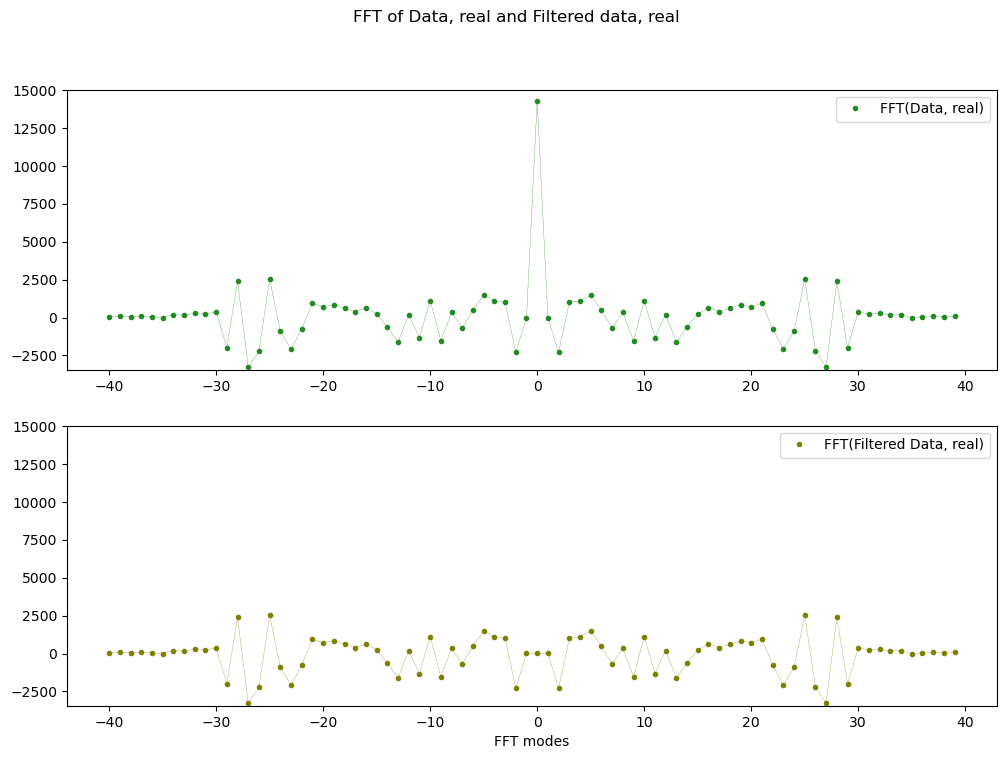

In [38]:
modes = np.arange(bl_data.size)-bl_data.size//2
plt.figure(figsize=(12, 8))
cut = 40

fr = fft(bl_data.real)
filtered_fr = fft(filtered_bl_data.real)
low, high = rlimits(fr.real, filtered_fr.real)

low = frates.size//2-cut
high = frates.size//2+cut
plt.subplot(2, 1, 1)
plt.plot(modes[low:high], fr.real[low:high], ".", label="FFT(Data, real)", color="forestgreen")
plt.plot(modes[low:high], fr.real[low:high], lw=0.2, color="forestgreen")
plt.ylim(min(np.min(fr.real), np.min(filtered_fr.real))*1.05, 
         max(np.max(fr.real), np.max(filtered_fr.real))*1.05)

plt.legend()
plt.subplot(2, 1, 2)

plt.plot(modes[low:high], filtered_fr.real[low:high], ".", label="FFT(Filtered Data, real)", color="olive")
plt.plot(modes[low:high], filtered_fr.real[low:high], lw=0.2, color="olive")
plt.xlabel("FFT modes")
plt.ylim(min(np.min(fr.real), np.min(filtered_fr.real))*1.05, 
         max(np.max(fr.real), np.max(filtered_fr.real))*1.05)
plt.legend()
plt.suptitle("FFT of Data, real and Filtered data, real")

Examine the FFT of the imag values of the data and filtered data

Text(0.5, 0.98, 'FFT of Data, real and Filtered data, imag')

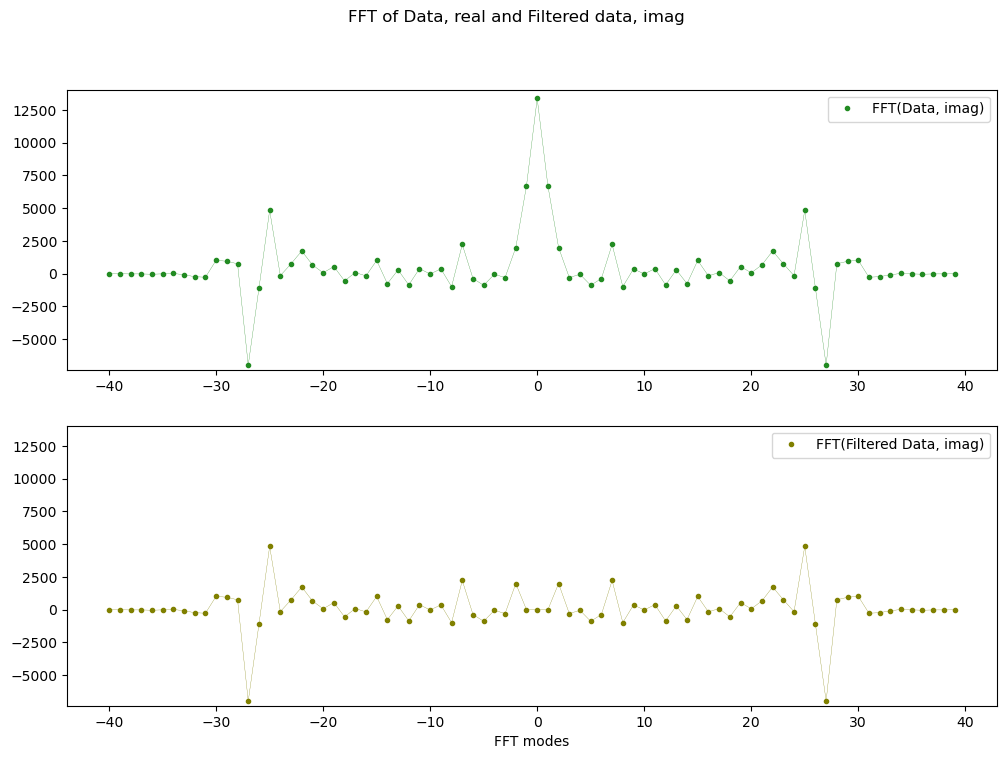

In [34]:
modes = np.arange(bl_data.size)-bl_data.size//2
plt.figure(figsize=(12, 8))
cut = 40

fr = fft(bl_data.imag)
filtered_fr = fft(filtered_bl_data.imag)
low, high = rlimits(fr.real, filtered_fr.real)

low = frates.size//2-cut
high = frates.size//2+cut
plt.subplot(2, 1, 1)
plt.plot(modes[low:high], fr.real[low:high], ".", label="FFT(Data, imag)", color="forestgreen")
plt.plot(modes[low:high], fr.real[low:high], lw=0.2, color="forestgreen")
plt.ylim(min(np.min(fr.real), np.min(filtered_fr.real))*1.05, 
         max(np.max(fr.real), np.max(filtered_fr.real))*1.05)

plt.legend()
plt.subplot(2, 1, 2)

plt.plot(modes[low:high], filtered_fr.real[low:high], ".", label="FFT(Filtered Data, imag)", color="olive")
plt.plot(modes[low:high], filtered_fr.real[low:high], lw=0.2, color="olive")
plt.xlabel("FFT modes")
plt.ylim(min(np.min(fr.real), np.min(filtered_fr.real))*1.05, 
         max(np.max(fr.real), np.max(filtered_fr.real))*1.05)
plt.legend()
plt.suptitle("FFT of Data, imag and Filtered data, imag")

Remove the DC from the data real/imag components (which is like filtering) and average and get the RMS.

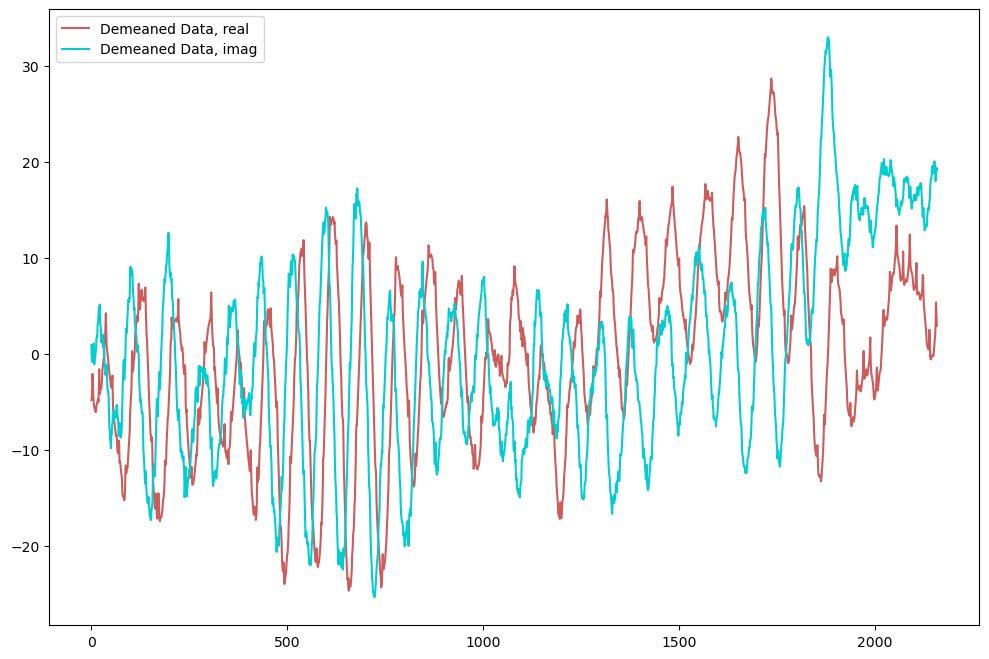

In [35]:
demeaned_data = bl_data-np.mean(bl_data)
plt.figure(figsize=(12, 8))
plt.plot(demeaned_data.real, label="Demeaned Data, real", color="indianred")
plt.plot(demeaned_data.imag, label="Demeaned Data, imag", color="darkturquoise")
plt.legend()

In [36]:
coh_avg = np.mean(demeaned_data)

In [37]:
print("Averaged demeaned data real:", coh_avg.real)
print("Averaged data imag:", coh_avg.imag)


Averaged demeaned data real: -4.2106236193191124e-16
Averaged data imag: 0.0
